# Expected Goals (xG) Analyses

This report/notebook is structured as follows:

**1. Data Exploration**

**2. xG Model (Expected Goals Model)**

**3. Conclusions about xG Model**

    3. a) How good is our model?

    3. b) How could we improve our model?

**4. Player Analysis**

    4. a) Which players are the best finishers?

    4. b) Which players have the most "expected goals"?

    4. c) Which players are the worst at deciding their shots?

    4. d) Which players are the best headers?

    4. e) Which players are the best at shooting with their left foot?

    4. f) Which players are the best at shooting with their right foot?

    4. g) Which are the best outside-the-box shooters?

    4. h) Which players make the best/most dangerous passes?

    4. i) Which players make the best/most dangerous crosses?

    4. j) Which players are the most unlucky when passing the ball?

We'll start by importing all that we might use later.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, precision_score, \
recall_score, cohen_kappa_score, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
pd.options.display.max_columns = 999
pd.options.display.max_rows = 50

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [2]:
filename = 'events.csv'

In [3]:
events = pd.read_csv(filename)

In [5]:
info = pd.read_csv('ginf.csv')

We add to our events dataset useful information from the ginf.csv, such as the league/country and the date.

In [7]:
events = events.merge(info[['id_odsp', 'country', 'date']], on='id_odsp', how='left')

In [8]:
extract_year = lambda x: datetime.strptime(x, "%Y-%m-%d").year
events['year'] = [extract_year(x) for key, x in enumerate(events['date'])]

We create a new dataset named Shots that will contain everything related to this action of the game and exclude the rest.

In [9]:
shots = events[events.event_type==1]
shots['player'] = shots['player'].str.title()
shots['player2'] = shots['player2'].str.title()
shots['country'] = shots['country'].str.title()

C:\Users\gmanf\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gmanf\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\gmanf\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

# 1. Data Exploration

Since in this notebook we will focus exclusively on analyzing Shots in football, we begin by exploring some charactersitics about this action of the game.

First, let's see how the different possible outcomes a shot can have are distributed.

In [10]:
pie = shots[['shot_outcome', 'id_event']].groupby('shot_outcome').count().reset_index().rename(columns={'id_event': 'count'})

In [11]:
pie.shot_outcome = pie.shot_outcome.astype(int)
pie.shot_outcome = pie.shot_outcome.replace({1: 'On Target', 2: 'Off Target', 3: 'Blocked', 4: 'Hit the Bar'})

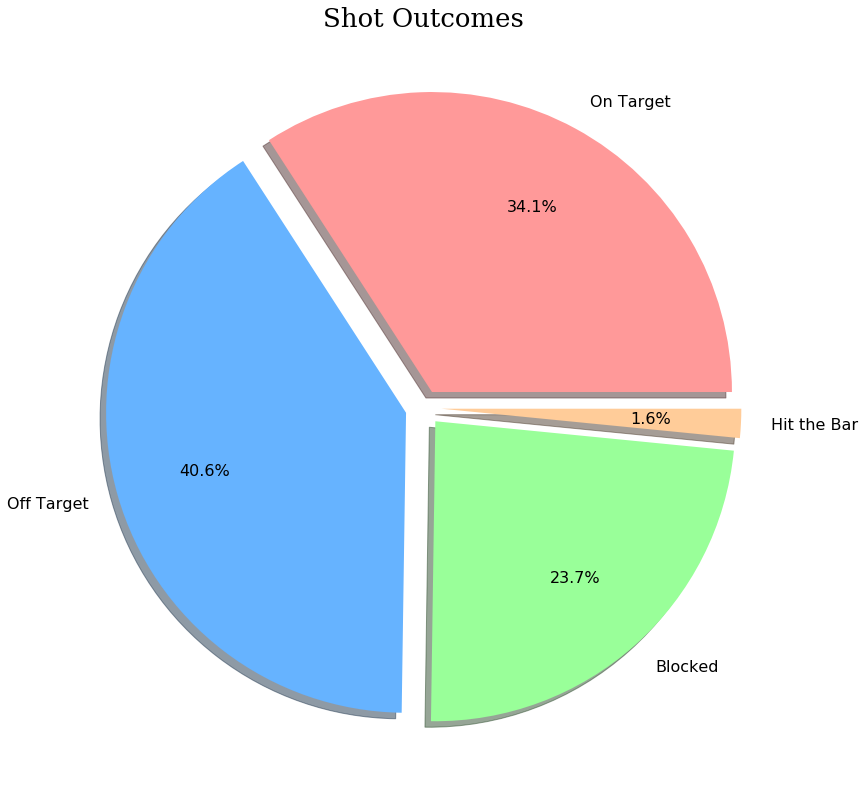

In [13]:
fig, ax = plt.subplots(figsize=[12,12])
labels = pie['shot_outcome']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.pie(x=pie['count'], autopct="%.1f%%", labels=labels, explode=[0.06]*4, pctdistance=0.7, colors=colors, shadow=True, \
       textprops=dict(fontsize=16))
plt.title("Shot Outcomes", fontsize=26, fontfamily='serif')
plt.tight_layout()
plt.show()

We see that most of the shots are off-target, but the difference with on-target shows is not so large. Of course only a fraction of those on-target shots end up as goals, because there is a goalkeeper trying to prevent goals on the other side.

Now let's explore where shots tend to be placed by the players.

In [15]:
bar = shots[['shot_place', 'id_event']].groupby('shot_place').count().reset_index().rename(columns={'id_event': 'count'})
bar.shot_place = bar.shot_place.astype(int)
bar.shot_place = bar.shot_place.replace({1: 'Bit too high', 2: 'Blocked', 3: 'Bottom left corner', 4: 'Bottom right corner', \
                                        5: 'Centre of the goal', 6: 'High and wide', 7: 'Hits the bar', 8: 'Misses to the left', \
                                        9: 'Misses to the right', 10: 'Too high', 11: 'Top centre of the goal', \
                                        12: 'Top left corner', 13: 'Top right corner'})

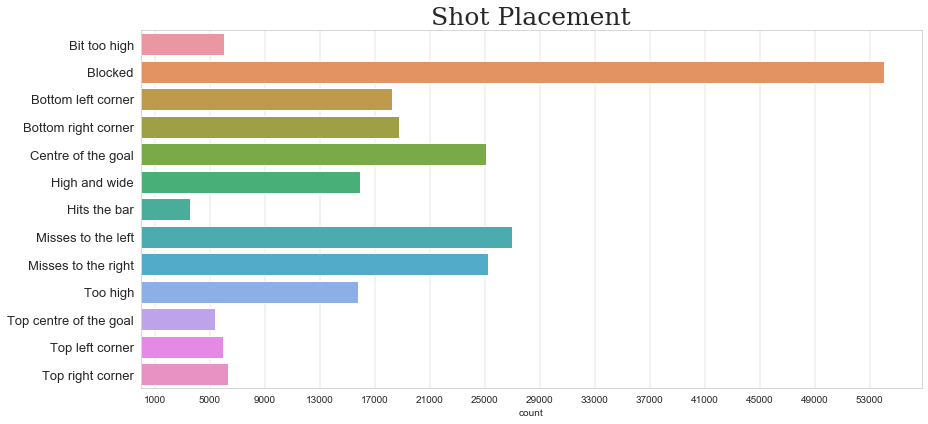

In [16]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=[13,6])
labels = bar['shot_place']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
ax = sns.barplot(x=bar['count'], y=labels)
ax.set_yticklabels(labels, size = 13)
ax.set_xticks(np.arange(1000,57000,4000))
ax.set_ylabel(ylabel='')
plt.title("Shot Placement", fontsize=25, fontfamily='serif')
plt.tight_layout()
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

We find that the majority of shots are blocked by opponents, but this is because all the not-blocked shots are grouped into many different categories. We have seen in the previous pie chart that in fact l24% of the shots are indeed blocked, which is still quite a high percentage.

From the shots that are not blocked, we see that the majority are either directed at the centre of the goal, or miss to the left or right side.

Now we'll explore something that will be quite important for our xG model: which percentage of shots end up as goals. We'll divide this analysis for the different leagues and across years, to check if there are differences in the patterns through different parts of the world or different years.

In [17]:
goals  = shots[['is_goal', 'id_event', 'country']].groupby(['is_goal', 'country']).count().reset_index().rename(columns={'id_event': 'count'})
goals.is_goal = goals.is_goal.replace({1: 'Goal', 0: 'No Goal'})

In [18]:
goals['percentage']=0
for i in range(len(goals)):
    for country in goals.country.unique():
        if goals.iloc[i,goals.columns.get_loc("country")]==country:
            goals.iloc[i,goals.columns.get_loc("percentage")]=goals.iloc[i,goals.columns.get_loc("count")] / \
                                                            goals[goals.country==country]['count'].sum()
goals['percentage']=round(goals['percentage']*100,2)

In [20]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}%'.format(p.get_height())
            ax.text(_x, _y+2, value, ha="center", fontsize=14) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

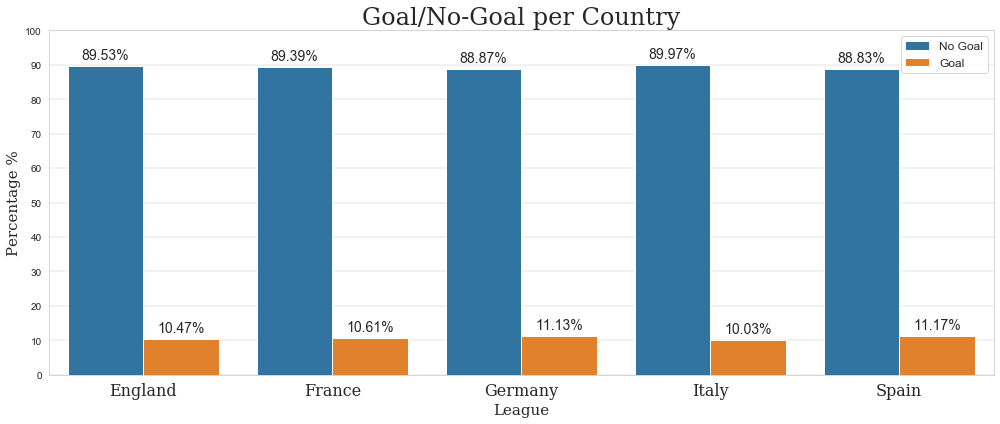

In [21]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=[14,6])
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
ax = sns.barplot(data=goals, y='percentage', hue='is_goal', x='country')
ax.set_yticks(np.arange(0,110,10))
ax.set_ylabel(ylabel='Percentage %', fontsize=15, fontfamily='serif')
ax.set_xlabel(xlabel='League', fontsize=15, fontfamily='serif')
ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=16, fontfamily='serif')
plt.title("Goal/No-Goal per Country", fontsize=24, fontfamily='serif')
plt.tight_layout()
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='y')
plt.legend(fontsize=12)
show_values_on_bars(ax)
plt.show()

There are barely any differences across the different main leagues. It seems that any given shot has a 10-11% chance of being a goal anywhere in the world.

In [23]:
goals  = shots[['is_goal', 'id_event', 'year']].groupby(['is_goal', 
                                                         'year']).count().reset_index().rename(columns={'id_event': 'count'})
goals.is_goal = goals.is_goal.replace({1: 'Goal', 0: 'No Goal'})

In [24]:
goals['percentage']=0
for i in range(len(goals)):
    for year in goals.year.unique():
        if goals.iloc[i,goals.columns.get_loc("year")]==year:
            goals.iloc[i,goals.columns.get_loc("percentage")]=goals.iloc[i,goals.columns.get_loc("count")] / \
                                                            goals[goals.year==year]['count'].sum()
goals['percentage']=round(goals['percentage']*100,2)

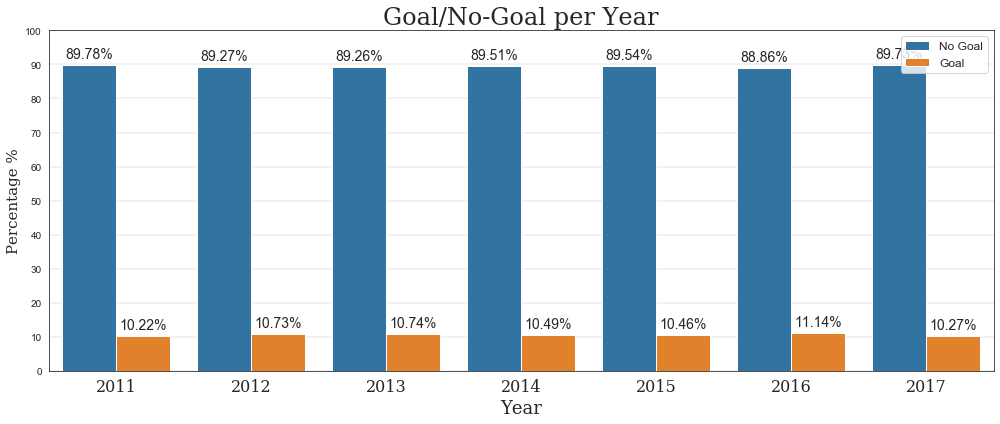

In [25]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=[14,6])
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
ax = sns.barplot(data=goals, y='percentage', hue='is_goal', x='year')
ax.set_yticks(np.arange(0,110,10))
ax.set_ylabel(ylabel='Percentage %', fontsize=15, fontfamily='serif')
ax.set_xlabel(xlabel='Year', fontsize=18, fontfamily='serif')
ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=16, fontfamily='serif')
plt.title("Goal/No-Goal per Year", fontsize=24, fontfamily='serif')
plt.tight_layout()
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='y')
plt.legend(fontsize=12)
show_values_on_bars(ax)
plt.show()

Again we find that the goal/no-goal ratios are nearly the same across time.

So it's becoming quite clear that statistically speaking 1 out of 9 to 10 shots are goals, no matter where or when you look at.

# 2. xG Model

Here we prepare the data for making it suitable as input for our xG Model. First I will talk a bit about what Expected Goals is.

Expected Goals Models are an attempt to quantify how likely it is that a certain shot results in a goal. With this metric, we can analyze what happened in a game other than how many goals each team scored. Since the game is won with goals, and goals come only from shots (except for the rare case of an own goal), then the xG metric only needs data from shots to be developed. In other words, anything else that may influence how many "expected goals" a team would score has to happen via having more shots in the first place. For example, one could argue that if team B receives 3 red cards, then team A is supposed to score more goals (an increase in expected goals). However, in reality, having 3 more players on the field will result in taking more (and possibly better) shots, and it is taking more shots that will result in an increase in expected goals. Therefore, shots and their information are the only thing we need to take into account!

I believe that an xG Model should not take into account specific characteristics or skills of the players who intervene in the event. I've read in some other places that xG models should account for this to be more accurate, but I strongly disagree. Of course that if Messi is one-on-one with the goalkeeper the chances of it being a goal are higher than with any other player. Or if Manuel Neuer is the goalkeeper then the probability of it being a goal may go down. But that is not the point of the metric. We are trying to standardize through thousands of datapoints how likely it is that any given player would score from a certain position in a certain situation. If the player is an extraordinary finisher, then he will probably score more goals than expected, and that's fine. If we start taking into account the skills of the players involved, it is my opinion that we would be taking one step too far towards the design of this metric and would become less meaningful.

After this (long) introduction, let's prepare X and Y sets. Y will simply include every shot in the database and whether it was a goal or not (1 or 0). It is our target variable. X will include all the relevant information about the shot that we have in our data. That would be:

. location: attacking half, defensive half, centre of the box, left wing, right wing, difficult angle and long range, difficult angle on the left, difficult angle on the right, left side of the box, left side of the six yard box, right side of the box, right side of the six yard box, very close range, penalty spot, outside the box, long range, more than 35 yards, more than 40 yards, not recorded.

. bodypart: right foot, left foot, head.

. assist_method: none, pass, cross, headed pass, through ball.

. situation: open play, set piece, corner, free kick.

. fast_break: 1 or 0, whether the shot comes from a fast break or not.

So, we have a lot of meaningful information about every shot. The location from which it was taken, which part of the body was used for shooting, how the shoot was made available (after a pass? a cross? etc.), and the situation or context in which the shoot occured (open play, corner, etc.)

Since all of these are categorical variables, we have to convert them to binary dummies (except for fast_break, which is already binary).

In [26]:
data = pd.get_dummies(shots.iloc[:,-8:-3], columns=['location', 'bodypart','assist_method', 'situation'])
data.columns = ['fast_break', 'loc_centre_box', 'loc_diff_angle_lr', 'diff_angle_left', 'diff_angle_right',
                'left_side_box', 'left_side_6ybox', 'right_side_box', 'right_side_6ybox', 'close_range',
                'penalty', 'outside_box', 'long_range', 'more_35y', 'more_40y', 'not_recorded', 'right_foot', 
                'left_foot', 'header', 'no_assist', 'assist_pass', 'assist_cross', 'assist_header',
                'assist_through_ball', 'open_play', 'set_piece', 'corner', 'free_kick']
data['is_goal'] = shots['is_goal']

In [27]:
print(len(data))
print(data.is_goal.sum())
print(len(data.columns)-1)

229135
24441
28


So we have a total of 229,135 shots, of which 24,441 were goals. For each shot, we have 28 different characteristics that describe it. All of these 28 characteristics are binary, so they just indicate Yes or No to a certain characteristics in the shot.

Now we will divide our X and y into two different sets for training and testing. I will use 65% of them for training our model and 35% por testing it. This is because we have enough datapoints, so 65% should be enough to train it properly and I'd rather have as many shots left as possible for pure testing later.

In [28]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=1)

## Gradient Boosting Classifier
We will first train a Gradient Boosting Classifier, which is a very powerful algorithm. It consists of an ensemble of decision trees. Because these trees tend to overfit to the training data, developing thousands of different trees making use of different predictors and samples each time helps us reduce the variance of our predictions within the famous bias vs variance tradeoff.

We use hyperopt to learn the best hyperparameters for tuning our model. I find hyperopt better than a normal grid search because in this way we there is some intelligence (another algorithm, in fact) trying to decide the best parameters for our model. It tries different settings all over the ranges that we give to it, and then sticks to the most promising ones.

In [29]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

def evaluate_model(params): 
    model = GradientBoostingClassifier(
                        learning_rate=params['learning_rate'],
                        min_samples_leaf=params['min_samples_leaf'],
                        max_depth = params['max_depth'],
                        max_features = params['max_features']
                        )

    model.fit(X_train, y_train)
    return {
        'learning_rate': params['learning_rate'],
        'min_samples_leaf': params['min_samples_leaf'],
        'max_depth': params['max_depth'],
        'max_features': params['max_features'],
        'train_ROCAUC': roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
        'test_ROCAUC': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),
        'recall': recall_score(y_test, model.predict(X_test)),
        'precision': precision_score(y_test, model.predict(X_test)),
        'f1_score': f1_score(y_test, model.predict(X_test)),
        'train_accuracy': model.score(X_train, y_train),
        'test_accuracy': model.score(X_test, y_test),
    }

def objective(params):
    res = evaluate_model(params)
    
    res['loss'] = - res['test_ROCAUC'] # Esta loss es la que hyperopt intenta minimizar
    res['status'] = STATUS_OK # Asi le decimos a hyperopt que el experimento salio bien
    return res 

hyperparameter_space = {
        'learning_rate': hp.uniform('learning_rate', 0.05, 0.3),
        'min_samples_leaf': hp.choice('min_samples_leaf', range(15, 200)),
        'max_depth': hp.choice('max_depth', range(2, 20)),
        'max_features': hp.choice('max_features', range(3, 27))
}

In [30]:
trials = Trials()
fmin(
    objective,
    space=hyperparameter_space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials
);

100%|███████████████████████████████████████████████| 20/20 [04:40<00:00, 14.03s/trial, best loss: -0.8193903838097742]


In [31]:
pd.DataFrame(trials.results).sort_values(by='f1_score', ascending=False).head(5)

,learning_rate,min_samples_leaf,max_depth,max_features,train_ROCAUC,test_ROCAUC,recall,precision,f1_score,train_accuracy,test_accuracy,loss,status
5,0.292582,44,9,25,0.819016,0.818554,0.268815,0.711706,0.390236,0.910580,0.910920,-0.818554,ok
15,0.298698,26,6,17,0.818807,0.818505,0.267992,0.713079,0.389573,0.910519,0.910945,-0.818505,ok
4,0.246339,149,18,6,0.818530,0.818896,0.267639,0.714375,0.389393,0.910412,0.910995,-0.818896,ok
18,0.189823,158,6,12,0.817854,0.819346,0.267286,0.716357,0.389312,0.910405,0.911083,-0.819346,ok
9,0.275527,120,12,4,0.818382,0.818827,0.267521,0.714510,0.389288,0.910479,0.910995,-0.818827,ok


We obtain the best results with the hyperparameters above, even though we see that there seem to be no very large differences when trying different values for the parameters. It's good to see that there are no signs of overfitting whatsoever, as our predictions are equally good for training and for testing examples.

In [32]:
model = GradientBoostingClassifier(
                        learning_rate=0.292582,
                        min_samples_leaf=44,
                        max_depth = 9,
                        max_features = 25
                        )
model.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.292582, loss='deviance', max_depth=9,
                           max_features=25, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=44, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Let's analyze the performance of the model with greater detail:

In [33]:
print('The test set contains {} examples (shots) of which {} are positive (goals).'.format(len(y_test), y_test.sum()))
print('The accuracy of classifying whether a shot is goal or not is {}%.'.format(round(model.score(X_test, y_test)*100),2))
print('Our classifier obtains an ROC-AUC of {}%'.format(round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])*100),2))

The test set contains 80198 examples (shots) of which 8504 are positive (goals).
The accuracy of classifying whether a shot is goal or not is 91.0%.
Our classifier obtains an ROC-AUC of 82.0%


So, we can see that our xG model is able to correctly predict whether a shot is goal or not 91% of the times. Furthermore, we obtain a pretty good ROC-AUC metric of 82%. This looks very promising.

However, these two metrics do not consider that our dataset is highly imbalanced. There are many more shots that do not end up being a goal than shots that do. So, for example, if we would simply predict that the shot will not be a goal each and every single time, we would already obtain an accuracy of 89%.

So we need other metrics to really understand if our model is any good.

Now we'll explore PR-AUC (Precision-Recall Under the Curve), and Cohen's Kappa statistic. Both of these are more appropiate for our case, since they do take into account the imbalance in our data.

In [34]:
print('The baseline performance for PR-AUC is {}%. This is the PR-AUC that what we would get by random guessing.'.format(round(y_train.mean(),2)))
print('Our model obtains an PR-AUC of {}%.'.format(round(average_precision_score(y_test, model.predict_proba(X_test)[:, 1])*100,2)))
print('Our classifier obtains a Cohen Kappa of {}.'.format(round(cohen_kappa_score(y_test,model.predict(X_test)),2)))

The baseline performance for PR-AUC is 0.11%. This is the PR-AUC that what we would get by random guessing.
Our model obtains an PR-AUC of 47.32%.
Our classifier obtains a Cohen Kappa of 0.35.


We end the evaluation of the model with a confusion matrix and an additional stats report.

In [35]:
print(color.BOLD + color.YELLOW + 'Confusion Matrix:\n' + color.END)
print(confusion_matrix(y_test,model.predict(X_test)))
print(color.BOLD +  color.YELLOW + '\n Report:' + color.END)
print(classification_report(y_test,model.predict(X_test)))

Confusion Matrix:

[[70768   926]
 [ 6222  2282]]

 Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     71694
           1       0.71      0.27      0.39      8504

    accuracy                           0.91     80198
   macro avg       0.82      0.63      0.67     80198
weighted avg       0.90      0.91      0.89     80198



The confusion matrix summarizes all predictions. It tells us that, from all the shots that were not goal, our model correctly identified 70,768 as no-goals, and made a mistake in 6,222 cases in which it predicted that the shot would not be a goal, but it was. From the other column, we see that it correctly predicted 926 goals, but failed to predict 2282 succesful shots as goals.

From the report we can see the model has excellent numbers when it comes to predict class 0 (no-goal), but not that good for predicting class 1 (goals). With the latter, we have a precision of 71%, and a recall of 27%, resulting in an F1 score of 0.39. These are decent numbers, but not really good.

Does this make sense? Of course it does. Predicting whether a shot will be goal and being right is extremely more difficult than correctly predicting it will not be a goal. This is particularly true if you have no idea who the player shooting the ball is or who the goalkeeper is, which is the situation in which the algorithm is in. It would be interesting to make a human vs. machine study on this. Are human experts much better in judging whether any given shot will become a goal than a model such as this one is?

## Logistic Regression

In [36]:
model = LogisticRegression(max_iter=400)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=400,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [37]:
print('The test set contains {} examples (shots) of which {} are positive (goals).'.format(len(y_test), y_test.sum()))
print('The accuracy of classifying whether a shot is goal or not is {}%.'.format(round(model.score(X_test, y_test)*100),2))
print('Our classifier obtains an ROC-AUC of {}%'.format(round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])*100),2))

The test set contains 80198 examples (shots) of which 8504 are positive (goals).
The accuracy of classifying whether a shot is goal or not is 91.0%.
Our classifier obtains an ROC-AUC of 82.0%


In [38]:
print('The baseline performance for PR-AUC is {}%. This is the PR-AUC that what we would get by random guessing.'.format(round(y_train.mean(),2)))
print('Our model obtains an PR-AUC of {}%.'.format(round(average_precision_score(y_test, model.predict_proba(X_test)[:, 1])*100,2)))
print('Our classifier obtains a Cohen Kappa of {}.'.format(round(cohen_kappa_score(y_test,model.predict(X_test)),2)))

The baseline performance for PR-AUC is 0.11%. This is the PR-AUC that what we would get by random guessing.
Our model obtains an PR-AUC of 47.08%.
Our classifier obtains a Cohen Kappa of 0.35.


In [39]:
print(color.BOLD + color.YELLOW + color.UNDERLINE + 'Confusion Matrix:\n' + color.END)
print(confusion_matrix(y_test,model.predict(X_test)))
print(color.BOLD +  color.YELLOW + color.UNDERLINE + '\n Report:' + color.END)
print(classification_report(y_test,model.predict(X_test)))

Confusion Matrix:

[[70820   874]
 [ 6265  2239]]

 Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     71694
           1       0.72      0.26      0.39      8504

    accuracy                           0.91     80198
   macro avg       0.82      0.63      0.67     80198
weighted avg       0.90      0.91      0.89     80198



We get almost exactly the same results as with Gradient Boosting. When this is the case, one should usually prefer the simpler model, in this case the Logistic Regression. However, there are 52 goals that were correctly recognized as such by the Gradient Boosting that were not captured by the Logistic Regression. Even though this is not a huge difference, I will choose the Gradient Boosting because of it.

In [40]:
model = GradientBoostingClassifier(
                        learning_rate=0.292582,
                        min_samples_leaf=44,
                        max_depth = 9,
                        max_features = 25
                        )
model.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.292582, loss='deviance', max_depth=9,
                           max_features=25, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=44, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

## Feature Importances
Let's take a look at which of our features are more relevant for our model to make the decisions as to whether each shot is a goal or not.

In [41]:
import eli5
eli5.explain_weights(model, feature_names=list(X_train.columns))

C:\Users\gmanf\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\gmanf\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight,Feature
0.1997 ± 0.0878,close_range
0.1933 ± 0.0783,penalty
0.1796 ± 0.0797,not_recorded
0.1060 ± 0.1442,outside_box
0.0930 ± 0.1729,loc_centre_box
0.0655 ± 0.0408,fast_break
0.0324 ± 0.1070,header
0.0293 ± 0.0855,assist_through_ball
0.0220 ± 0.1249,assist_cross
0.0175 ± 0.0451,left_side_6ybox


We see that most of the shot-location clues (close range, centre of the box, outside of the box) stand among the most relevant, as expected. One thing to worry about is the high coefficient of the location=not_recorded. Apparently there are shots for which the location has not been recorded, and for some reason those shots are extremely likely to be goals. This makes things easier for the model. To better understand the model, it could be interesting to remove those rows and check its performance. I have tried it and it results in a slight decrease in performance (ROC-AUC=0.806, PR-AUC = 0.41), so no too large differences. I will leave these rows anyway, as I will do players' analyses later and I don't want valuable information about the goals of the players being erased.

# 3. Conclusions about xG Model

## 3.a) How good is our model?

It is hard to determine whether the model is good, as there is not much to compare with. I think that Cohen's Kappa and PR-AUC PR are the best indicators we have to measure its performance, but it's not easy to find these numbers for other different xG models for comparison. Many report the aggregated R2 by season, but that does not make a lot of sense. In Section 4 we will see that our model results in a correlation of 0.97 between the total expected goals and the actual goals by player, suggesting that the model may be sufficiently good, but this measure is also not ideal.

While searching for other xG models and how well they've done, to be able to compare how good this is, I found the following regarding AUC-ROC in other models (see here):

. Standard Model: ROC-AUC = 79.8%

. Big Chance Model: ROC-AUC = 75.1%

. Standard+Big Chance: ROC-AUC = 82%

. Standard+Defensive = ROC-AUC = 81.4%

So then we can compare this model with others, at least on this statistic, which as I have mentioned before I don't think is the best one to determine how well the model performs.

Our model has a ROC-AUC of 81.9%, suggesting it is pretty decent, at least compared to those.

## 3.b) How could we improve our xG model?

I've tried different algorithms with different hyperparameters and the results did not change much.

But, what additional data could we add to improve our model? First, it would be great to have information about the defending team. How many defenders are between the goal and the player with the ball? How much defensive pressure is the shooting player withstanding? How much time/space does the player have in order to shoot? I imagine the (quantified) answers to many of these questions could give the model interesting new information to base its predictions on.

Additionally, we have the location of the shot divided in 17 different categories. This is good, but it could be better to have exact x and y coordinates of where the player is. This could lead to more precision in the location of each shot, and therefore in the predictions of the model.

# 4. Player Analysis

We'll start by adding the information we have about expected goals to each shot in our original data. From there, we can extract many interesting metrics about players, all of these metrics being related in one way or another to the new xG predictions for each shot.

In [42]:
shots['prediction'] = model.predict_proba(X)[:, 1]
shots['difference'] = shots['prediction'] - shots['is_goal']

C:\Users\gmanf\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\gmanf\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## 3.a) Which players are the best finishers?

By looking at the difference between a player's number of goals and his number of expected goals, we can see who are the best at finishing plays. We can approach this problem from two different points of view:

1- Look at the difference between total goals scored and total expected goals: This will tell us which player scored the highest number of goals compared to what he was expected to score.

2- Look at the ratio between total goals scored and total expected goals: This will tell us precisely the relation of how many goals the player actually scores for each goal he was supposed to score.

In [43]:
players = shots.groupby('player').sum().reset_index()
players.rename(columns={'is_goal': 'trueGoals', 'prediction': 'expectedGoals'}, inplace=True)
players.expectedGoals = round(players.expectedGoals,2)
players.difference = round(players.difference,2)
players['ratio'] = players['trueGoals'] / players['expectedGoals']

In [44]:
print(round(players.expectedGoals.corr(players.trueGoals),3))

0.977


As mentioned above, we see that the correlation between trueGoals and expectedGoals is very high, which speaks well about our xG model.

#### Best Finishers

In [45]:
show = players.sort_values(['difference', 'trueGoals']).reset_index(drop=True)
show['rank'] = show.index+1
show = show[['rank', 'player', 'difference', 'trueGoals', 'expectedGoals']].head(10)
show.head(5)

,rank,player,difference,trueGoals,expectedGoals
0,1,Lionel Messi,-58.83,205,146.17
1,2,Zlatan Ibrahimovic,-33.83,153,119.17
2,3,Cristiano Ronaldo,-32.32,198,165.68
3,4,Gonzalo Higuain,-31.88,118,86.12
4,5,Luis Suarez,-31.80,96,64.20


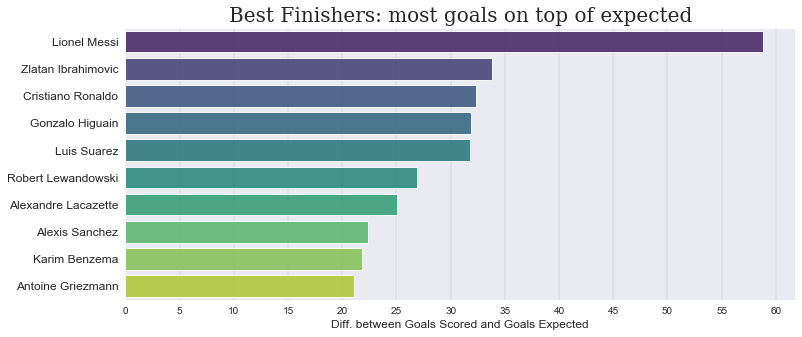

In [46]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[12,5])
ax = sns.barplot(x=abs(show['difference']), y=show['player'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,65,5))
ax.set_xlabel(xlabel='Diff. between Goals Scored and Goals Expected', fontsize=12)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Best Finishers: most goals on top of expected", fontsize=20, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, alpha=0.8, axis='x')
plt.show()

Not surprisingly, we can see that Messi is much better than everyone else on this metric. According to the number and characteristics of all shoots he's taken, he was expected to score 146 goals, but instead he has scored 205. As expected, what we find among the top of the list are all world-class famous players.

Remember that we are looking at absolute values here, that is, total goals. Let's see what happens when we look instead at the goalsScored / expectedGoals ratio. We'll keep only players who scored more than 30 goals in total (the data covers an 8-years span, so 30 goals is not much).

In [47]:
show = players[players['trueGoals']>30].sort_values(['ratio', 'trueGoals'], ascending=False).reset_index(drop=True)
show['rank'] = show.index+1
show = show[['rank', 'player', 'ratio', 'trueGoals', 'expectedGoals']].head(10)
show.head(5)

,rank,player,ratio,trueGoals,expectedGoals
0,1,Franck Ribery,1.893939,40,21.12
1,2,Mario Gotze,1.573129,37,23.52
2,3,Bas Dost,1.555076,36,23.15
3,4,Heungmin Son,1.521636,32,21.03
4,5,Luis Suarez,1.495327,96,64.20


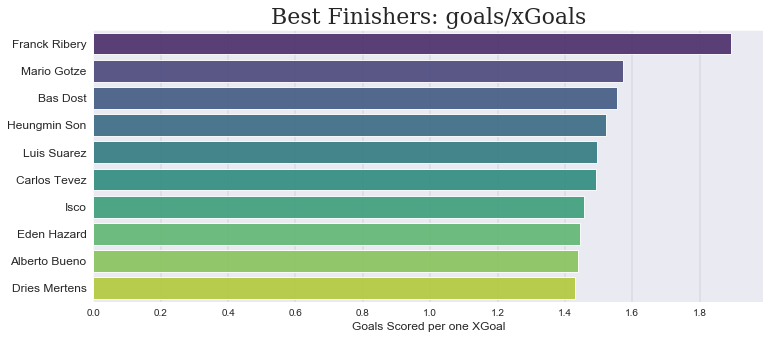

In [48]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[12,5])
ax = sns.barplot(x=show['ratio'], y=show['player'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,1.9,0.2))
ax.set_xlabel(xlabel='Goals Scored per one XGoal', fontsize=12)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Best Finishers: goals/xGoals", fontsize=22, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

We find Ribery at the most prolific finisher in the game. One nice thing about this metric is that it is very easy to interpret. It corresponds to the proportion of goals that the player scored as compared to how many he would have scored if he executed his shots like the average player. In this case of Ribery, from each goal he was supposed to score according of the number and context of his shots, he scored almost two.

#### Best Finishers per Year per League

Another interesting analysis is to repeat this last exercise for every year. So who was the best finisher of each calendar year in our data?

In [49]:
players_per_year = shots.groupby(['year', 'country', 'player']).sum().reset_index()
players_per_year.rename(columns={'is_goal': 'trueGoals', 'prediction': 'expectedGoals'}, inplace=True)
players_per_year.expectedGoals = round(players_per_year.expectedGoals,2)
players_per_year.difference = round(players_per_year.difference,2)
players_per_year['ratio'] = players_per_year['trueGoals'] / players_per_year['expectedGoals']
players_per_year['ratio'] = round(players_per_year.ratio, 2)

In [50]:
def best_finishers_per_year(years, leagues, min_goals, df):
    years_res=[]; leagues_res=[]; players_res=[]; ratio_res=[]; goals=[]
    players_per_year = df[df['trueGoals']>min_goals]
    for league in leagues:
        for year in years:
            results = players_per_year[(players_per_year['year']==year) & (players_per_year['country']==league)].sort_values(by='ratio', ascending=False).reset_index(drop=True)
            results['rank'] = results.index + 1
            if len(results)>0:
                years_res.append(year)
                leagues_res.append(league)
                players_res.append(results[results['rank']==1]['player'].iloc[0])
                ratio_res.append(results[results['rank']==1]['ratio'].iloc[0])
                goals.append(results[results['rank']==1]['trueGoals'].iloc[0])
    return years_res, leagues_res, players_res, ratio_res, goals

In [51]:
years, leagues, players_res, ratio, goals = best_finishers_per_year(years = players_per_year.year.unique(), 
                                                                    leagues=players_per_year.country.unique(),
                                                                    min_goals=12, 
                                                                    df=players_per_year)

In [52]:
results_perYear = pd.DataFrame()
results_perYear['League']=leagues
results_perYear['Year']=years
results_perYear['bestFinisher']=players_res
results_perYear['Goals']=goals
results_perYear['Goals/xGoals Ratio']=ratio
results_perYear

,League,Year,bestFinisher,Goals,Goals/xGoals Ratio
0,France,2011,Olivier Giroud,13,1.22
1,France,2012,Zlatan Ibrahimovic,18,1.46
2,France,2013,Dario Cvitanich,16,1.71
3,France,2014,Cheick Diabate,13,1.61
4,France,2015,Benjamin Moukandjo,13,1.69
5,France,2016,Zlatan Ibrahimovic,21,2.27
6,Germany,2011,Klaasjan Huntelaar,15,1.76
7,Germany,2012,Martin Harnik,15,1.78
8,Germany,2013,Ivica Olic,13,2.23
9,Germany,2014,Josip Drmic,14,2.03


#### Worst finishers
Now let's see what happens at the other end of the spectrum

In [53]:
show = players.sort_values(['difference', 'trueGoals']).reset_index(drop=True)
show['rank'] = show.index+1
show = show[['rank', 'player', 'difference', 'trueGoals', 'expectedGoals']].tail(10)
show.tail(3)

,rank,player,difference,trueGoals,expectedGoals
4784,4785,Mats Hummels,8.91,10,18.91
4785,4786,Amauri,12.04,20,32.04
4786,4787,Jesus Navas,14.60,9,23.60


In [54]:
show = players[players['trueGoals']>30].sort_values(['ratio', 'trueGoals'], ascending=False).reset_index(drop=True)
show['rank'] = show.index+1
show = show.sort_values(by='rank', ascending=False)
show = show[['rank', 'player', 'ratio', 'trueGoals', 'expectedGoals']].head(10)
show.head(3)

,rank,player,ratio,trueGoals,expectedGoals
140,141,Giampaolo Pazzini,0.781250,31,39.68
139,140,Mario Balotelli,0.813743,36,44.24
138,139,Gonzalo Bergessio,0.845839,31,36.65


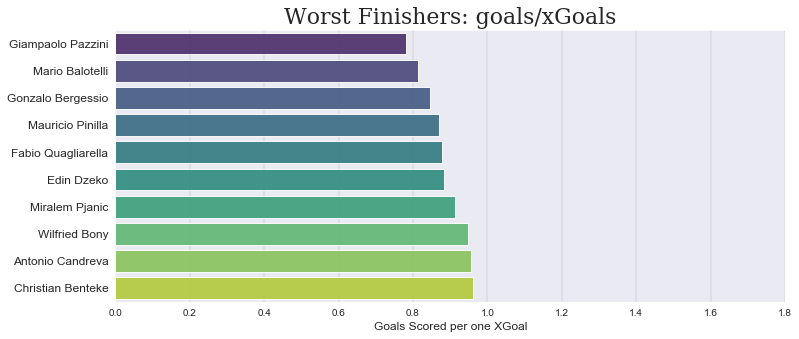

In [55]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[12,5])
ax = sns.barplot(x=show['ratio'], y=show['player'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,1.9,0.2))
ax.set_xlabel(xlabel='Goals Scored per one XGoal', fontsize=12)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Worst Finishers: goals/xGoals", fontsize=22, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

We find players like Mario Balotelli, Giampaolo Pazzini, or Edin Dzeko, among others, who have scored much less goals that what they should have. Giampaolo Pazzini is actually on both lists (total absolute difference in goals and trueGoals/xGoals ratio).

Looking at players with much fewer goals than expected goals is interesting. It kind of tells us that these players have missed too many chances and should improve their shooting. But it also means that they have been there creating many more scoring chances than what the most widespread stats (like goals) tell us. So, in that sense, they are underrated.

## 3.b) Which players have the most "expected goals"?
For this we simply order our table by expectedGoals. It tell us which players should have scored the highest number of goals according to all the chances that they've had, as predicted by our model.

In [56]:
show = players[['player', 'trueGoals', 'expectedGoals']].sort_values(['expectedGoals'], ascending=False).head(10)
show.head(5)

,player,trueGoals,expectedGoals
944,Cristiano Ronaldo,198,165.68
2745,Lionel Messi,205,146.17
4779,Zlatan Ibrahimovic,153,119.17
1277,Edinson Cavani,121,114.14
3971,Robert Lewandowski,124,97.10


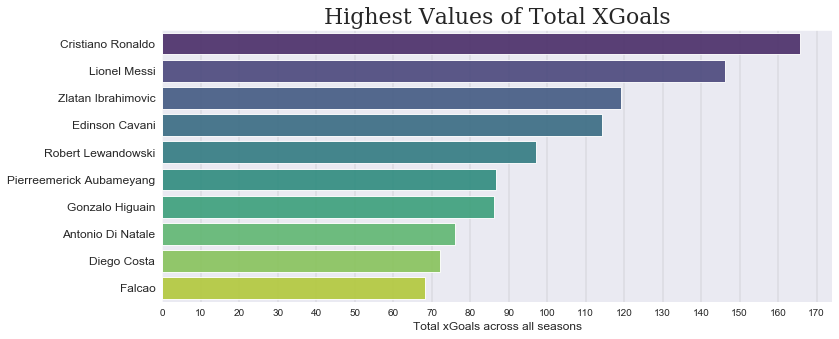

In [57]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[12,5])
ax = sns.barplot(x=show['expectedGoals'], y=show['player'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,180,10))
ax.set_xlabel(xlabel='Total xGoals across all seasons', fontsize=12)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Highest Values of Total XGoals", fontsize=22, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

## 3.c) Which players are the worst at deciding their shots?
By studying the relationship between the players' total expected goals and the total number of shots they attempted, we can determine which players make the worst shooting decisions. That is, that they consistently tend to take shots that are not likely to end up as goals. We will only include players who have taken a minimum of 100 shots, as otherwise the results would be filled with players who attempted only 1 or 2 (very bad) shots in the entire 7-year period.

In [58]:
# Because event_type is always one in our data, we can use it its sum as the total number of shots each player took.
players.rename(columns={'event_type': 'n_shots'}, inplace=True)

In [59]:
players['xG_per_shot_ratio'] = players['expectedGoals'] / players['n_shots']
show = players[players['n_shots']>100].sort_values(['xG_per_shot_ratio', 'trueGoals'], ascending=False).reset_index(drop=True)
show['rank'] = show.index+1
show[['rank', 'player', 'xG_per_shot_ratio', 'trueGoals', 'expectedGoals', 'difference']].tail(5)

,rank,player,xG_per_shot_ratio,trueGoals,expectedGoals,difference
669,670,Daniel Baier,0.042034,5,7.44,2.44
670,671,Ivan Radovanovic,0.040932,2,6.59,4.59
671,672,Florent Balmont,0.036845,5,6.19,1.19
672,673,Gokhan Inler,0.035676,9,6.60,-2.40
673,674,Tom Huddlestone,0.030463,2,3.29,1.29


We can see that Tom Huddlestone appears to be the worst at deciding when to shoot, with an xG per shot of 0.03.

The cases of Gohhan Inler and Ruben Rochina are really interesting. They seem to take a lot of very unlikely shots, from long distance, but it also seems that they are actually good at it. Look at the difference between their actual goals and their expected goals: despite taking "bad" shots, they have scored more than they were expected to. So, in their case, making these kinds of shots might not be such a bad decision after all.

On the other hand, we have cases like Ivan Radovanovic. He also has taken a lot of shots from unlikely locations, and he does not seem to be good at it, since he only has 2 goals when his expected goals are 6.6. These shots may also come in situations after corners, in which players sometimes shoot from far away in any direction without any hope of making a goal, but instead for the ball to go out and reorganize the defense. So maybe these bad shots did make sense in a way and we should not be so cruel about it.

At the bottom at the list we find the players who tend to take shots that are likely to be goals, from inside the box or very close range. As expected, here we find mostly strikers and target-men, who tend to play near the opposition's goal. Diego Milito, Kevin Gameiro, and Carlos Bacca are among these players. For example, Diego Milito had an average xGoal per shot of 0.21, which means that, on average, every shot he took had more than 20% chance of being a goal according to our model. In other words, it looks like he only took good/safe shots and did not risk too much.

In [60]:
show = show[['rank', 'player', 'xG_per_shot_ratio', 'trueGoals', 'expectedGoals', 'difference']].head(10)
show.head(5)

,rank,player,xG_per_shot_ratio,trueGoals,expectedGoals,difference
0,1,Diego Milito,0.208841,33,28.82,-4.18
1,2,Kevin Gameiro,0.194455,63,58.92,-4.08
2,3,Ikechukwu Uche,0.193097,21,21.82,0.82
3,4,Carlos Bacca,0.191913,57,44.14,-12.86
4,5,Miku,0.191284,23,20.85,-2.15


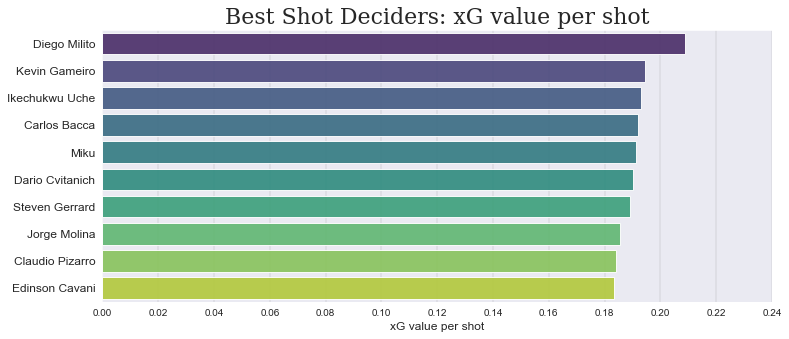

In [61]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[12,5])
ax = sns.barplot(x=show['xG_per_shot_ratio'], y=show['player'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,0.25,0.02))
ax.set_xlabel(xlabel='xG value per shot', fontsize=12)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Best Shot Deciders: xG value per shot", fontsize=22, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

## 3.d) Which players are the best headers?

In [62]:
headers = shots[(shots.event_type==1) & (shots.bodypart==3)]
headers_players = headers.groupby('player').sum().reset_index()
headers_players.rename(columns={'event_type': 'n_headers', 'is_goal': 'trueGoals', 'prediction': 'expectedGoals'}, inplace=True)
headers_players['ratio'] = headers_players['trueGoals'] / headers_players['expectedGoals']
show_headers = headers_players.sort_values(['difference', 'trueGoals']).reset_index(drop=True)
show_headers['rank'] = show_headers.index+1
show_headers[['rank', 'player', 'n_headers', 'trueGoals', 'expectedGoals', 'difference']].head(5)

,rank,player,n_headers,trueGoals,expectedGoals,difference
0,1,Cristiano Ronaldo,159,36,19.972000,-16.028000
1,2,Mario Mandzukic,124,28,14.805278,-13.194722
2,3,Fernando Llorente,141,25,15.924402,-9.075598
3,4,Sloan Privat,86,17,9.924180,-7.075820
4,5,Pierreemerick Aubameyang,59,14,7.351104,-6.648896


We see that Cristiano Ronaldo is the best header in the game, when comparing the number of goals he scored with his head with the number of goals he should have scored with our model. The other two in the top 3 are Mario Mandzukic and Fernando Llorente.

This is interesting because we can easily see how it confirms something we kind of know. These three guys are exceptional at heading the ball.

## 3.e) Which players are the best at shooting with their left foot?

In [63]:
left_foot = shots[(shots.event_type==1) & (shots.bodypart==2)]
left_foot_players = left_foot.groupby('player').sum().reset_index()
left_foot_players.rename(columns={'event_type': 'n_leftFoot_shots', 'is_goal': 'trueGoals', 'prediction': 'expectedGoals'}, inplace=True)
show_lfoot = left_foot_players.sort_values(['difference', 'trueGoals']).reset_index(drop=True)
show_lfoot['rank'] = show_lfoot.index+1
show_lfoot[['rank', 'player', 'n_leftFoot_shots', 'trueGoals', 'expectedGoals', 'difference']].head(5)

,rank,player,n_leftFoot_shots,trueGoals,expectedGoals,difference
0,1,Lionel Messi,752,167,121.560159,-45.439841
1,2,Antoine Griezmann,345,58,41.504923,-16.495077
2,3,Arjen Robben,296,42,32.091555,-9.908445
3,4,Iago Falque,132,23,13.262515,-9.737485
4,5,Franck Ribery,57,16,6.494795,-9.505205


Of course Messi is first on the list. He is the one who scored the most with his left foot when compared to what was expected according to the characteristics surrounding the shot. The list is complete with Antoine Griezmann, Iago Falque, and Arjen Robben. Not surprisingly, these players are all left-footed.

I'm a bit surprised by not seeing Cristiano Ronaldo here, as I remember him scoring many times with his left foot. So I'll look him up individually.

In [64]:
show_lfoot[show_lfoot.player=='Cristiano Ronaldo'][['rank', 'player', 'expectedGoals', 'trueGoals']]

,rank,player,expectedGoals,trueGoals
79,80,Cristiano Ronaldo,28.467235,32


He still has more left-footed goals than what was expected by our model, so we can confirm that he is very decent at shooting with his left. But he is not among the best either (he is 80th).

Now let's see what happens when we look at the ratio instead of the total values.

In [65]:
left_foot_players['ratio'] = left_foot_players['trueGoals'] / left_foot_players['expectedGoals']
show_lfoot = left_foot_players[left_foot_players['trueGoals']>20].sort_values(['ratio', 'trueGoals'], ascending=False).reset_index(drop=True)
show_lfoot['rank'] = show_lfoot.index+1
show_lfoot[['rank', 'player', 'n_leftFoot_shots', 'trueGoals', 'expectedGoals', 'ratio']].head(5)

,rank,player,n_leftFoot_shots,trueGoals,expectedGoals,ratio
0,1,Iago Falque,132,23,13.262515,1.734211
1,2,Mohamed Salah,129,23,13.810848,1.665358
2,3,Lukas Podolski,132,21,13.214608,1.589150
3,4,James Rodriguez,162,23,15.515819,1.482358
4,5,Zlatan Ibrahimovic,129,25,17.313639,1.443948


Some new players like Mohamed Salah appear now as very proficient left-foot finishers.

## 3.f) Which players are the best at shooting with their right foot?

In [66]:
right_foot = shots[(shots.event_type==1) & (shots.bodypart==1)]
right_foot_players = right_foot.groupby('player').sum().reset_index()
right_foot_players.rename(columns={'event_type': 'n_rightFoot_shots', 'is_goal': 'trueGoals', 'prediction': 'expectedGoals'}, inplace=True)
show = right_foot_players.sort_values(['difference', 'trueGoals']).reset_index(drop=True)
show['rank'] = show.index+1
show[['rank', 'player', 'n_rightFoot_shots', 'trueGoals', 'expectedGoals', 'difference']].head(5)

,rank,player,n_rightFoot_shots,trueGoals,expectedGoals,difference
0,1,Luis Suarez,289,69,43.168156,-25.831844
1,2,Gonzalo Higuain,362,86,60.727727,-25.272273
2,3,Alexandre Lacazette,270,70,48.348284,-21.651716
3,4,Zlatan Ibrahimovic,554,111,90.911593,-20.088407
4,5,Robert Lewandowski,378,84,65.531667,-18.468333


We see Luis Suarez at the top of the list. Messi is in the 13th position besides right foot being his weak foot and the model not accounting for that, which is pretty amazing (the model doesn't know whether a player is right or left footed, it just knows which foot was used for shooting).

Again we also check the ratio instead of the total values to see if we have a different scenario.

In [67]:
right_foot_players['ratio'] = right_foot_players['trueGoals'] / right_foot_players['expectedGoals']
show_rfoot = right_foot_players[right_foot_players['trueGoals']>20].sort_values(['ratio', 'trueGoals'], ascending=False).reset_index(drop=True)
show_rfoot['rank'] = show_rfoot.index+1
show_rfoot[['rank', 'player', 'n_rightFoot_shots', 'trueGoals', 'expectedGoals', 'ratio']].head(5)

,rank,player,n_rightFoot_shots,trueGoals,expectedGoals,ratio
0,1,Bas Dost,62,23,13.017076,1.766910
1,2,Carlos Tevez,181,33,19.823173,1.664718
2,3,Franck Ribery,165,24,14.417805,1.664608
3,4,Luis Suarez,289,69,43.168156,1.598400
4,5,Lionel Messi,109,30,18.781957,1.597278


Another interesting exercise is to pick some players and compare them in terms of their finishing proficency with each part of the body.

Let's take 4 top players to illustrate this example: Messi, Cristiano Ronaldo, Zlatan Ibrahimovic, and Robert Lewandowski.

In [68]:
right_foot = right_foot_players[right_foot_players['n_rightFoot_shots']>5]
left_foot = left_foot_players[left_foot_players['n_leftFoot_shots']>5]
headers = headers_players[headers_players['n_headers']>5]
all_players = right_foot[['player']].merge(left_foot, on='player', how='inner').merge(headers, on='player', how='inner')                                                                         
all_players_list = list(all_players['player'].unique())

def compare_players(players_list):
    total = right_foot[right_foot['player'].isin(players_list)][['player', 'ratio']]
    total['bodypart']='Right Foot'
    left_foot['bodypart']='Left Foot'
    headers['bodypart']= 'Header'
    total = pd.concat([total, left_foot[left_foot['player'].isin(players_list)][['player', 'ratio', 'bodypart']], headers[headers['player'].isin(players_list)][['player', 'ratio', 'bodypart']]], axis=0)

    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=[15,8])
    ax = sns.barplot(y=total['ratio'], x=total['player'], hue=total['bodypart'], palette='viridis', alpha=0.9)
    #ax.set_yticks(np.arange(0,2.2,0.2))
    ax.set_ylabel(ylabel='Goals per xG Ratio', fontsize=14)
    ax.set_xlabel(xlabel='')
    ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=15)
    plt.title("Players Comparison", fontsize=24, fontfamily='serif')
    ax.grid(color='black', linestyle='-', linewidth=0.1, axis='y')
    plt.legend(fontsize=12)
    plt.show()


C:\Users\gmanf\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\gmanf\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


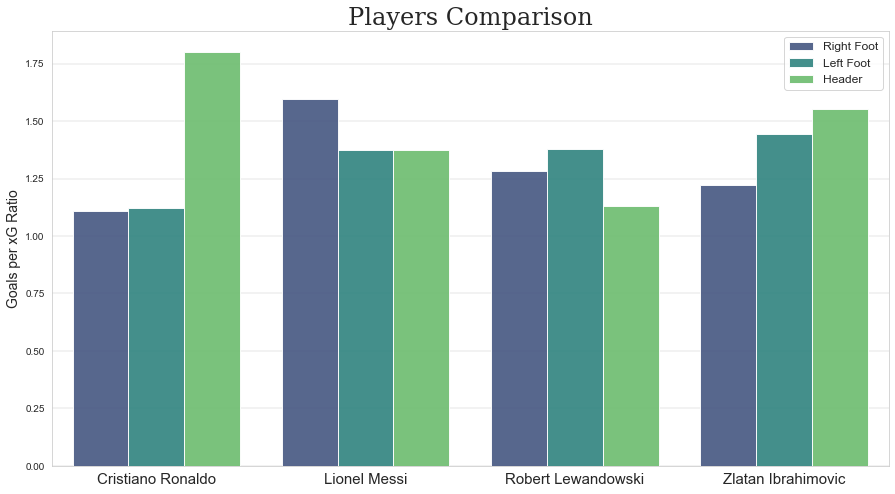

In [69]:
compare_players(players_list = ['Lionel Messi', 'Cristiano Ronaldo', 'Zlatan Ibrahimovic', 'Robert Lewandowski'])

We see that Ronaldo is the best header and Lewandowski the worst of the four. Messi is the best left-foot finisher, while Zlatan seems to be the best with his right foot.

One interesting thing to note is that all four players are above the 1.0 mark for all bodyparts. This means that they all do better than expected when shooting either with the head, left, or right foot. This is very impressive and makes it clear why they are considered elite players.

Let's take four random players and compare them to see the contrast:

C:\Users\gmanf\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\gmanf\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


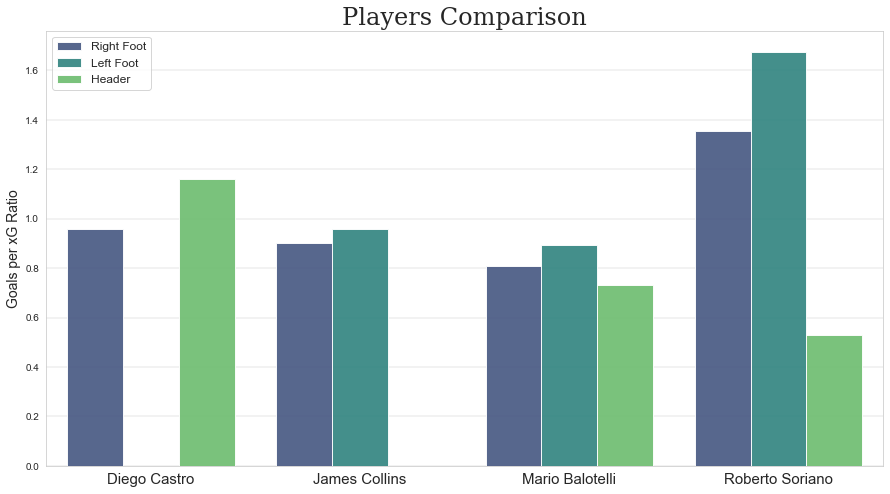

In [84]:
import random
compare_players(random.sample(all_players_list, 4))

We see that even though the random players can show some high value, they show less consistency and many values are below 1.0. It may also be possible that the appearance of high values is due to the fact that they did not take many shots, so scoring only 1 goal can skyrocket the metric.

## 3.g) Which are the best outside-the-box shooters?

In [85]:
outside_box = shots[(shots.location==15)]
outbox_players = outside_box.groupby('player').sum().reset_index()
outbox_players.rename(columns={'event_type': 'n_outbox_shots', 'is_goal': 'trueGoals', 'prediction': 'expectedGoals'}, inplace=True)
show = outbox_players.sort_values(['difference', 'trueGoals']).reset_index(drop=True)
show['rank'] = show.index+1
show[['rank', 'player', 'n_outbox_shots', 'trueGoals', 'expectedGoals', 'difference']].head(5)

,rank,player,n_outbox_shots,trueGoals,expectedGoals,difference
0,1,Lionel Messi,304,16,6.359869,-9.640131
1,2,Paul Pogba,226,14,5.972058,-8.027942
2,3,Zlatan Ibrahimovic,261,14,6.784960,-7.215040
3,4,Gonzalo Higuain,127,11,3.846460,-7.153540
4,5,Yaya Toure,128,10,3.379026,-6.620974


In [86]:
show[['rank', 'player', 'n_outbox_shots', 'trueGoals', 'expectedGoals', 'difference']].tail(5)

,rank,player,n_outbox_shots,trueGoals,expectedGoals,difference
4143,4144,Alberto Aquilani,117,0,3.138028,3.138028
4144,4145,Ronny Rodelin,119,0,3.195280,3.195280
4145,4146,Francesco Lodi,170,0,3.454661,3.454661
4146,4147,Alessandro Diamanti,254,3,6.503888,3.503888
4147,4148,Mario Balotelli,209,1,4.725769,3.725769


We see Messi, Pogba, and Zlatan as the ones who scored the most goals from outside the box compared to what they were expected to. In the other end, we find players like Mario Balotelli and Alessandro Diamanti. I'm surprised to see Nainggolan among the worst (4120th position), as I recall him as an excellent shooter from long range, scoring many goals. But maybe that's just because he actually tried 280 shots and I only remember the ones that were goals. This is a largely proven psychological bias. For these cases, better rely on the numbers.

Again let's see the top players from the trueGoals/xGoals ratio perspective. We'll only consider players who attempted more than 80 shots from outside the box in total (~12 per year):

In [87]:
outbox_players['ratio'] = outbox_players['trueGoals'] / outbox_players['expectedGoals']
show = outbox_players[outbox_players['n_outbox_shots']>80].sort_values(['ratio', 'trueGoals'], ascending=False).reset_index(drop=True)
show['rank'] = show.index+1
show = show[['rank', 'player', 'n_outbox_shots', 'trueGoals', 'expectedGoals', 'ratio']].head(10)
show.head(5)

,rank,player,n_outbox_shots,trueGoals,expectedGoals,ratio
0,1,James Rodriguez,105,9,2.425977,3.709845
1,2,Alain Traore,86,6,1.836311,3.267421
2,3,Julian Draxler,94,8,2.606829,3.068863
3,4,Alexandre Lacazette,100,9,2.954933,3.045755
4,5,Yaya Toure,128,10,3.379026,2.959432


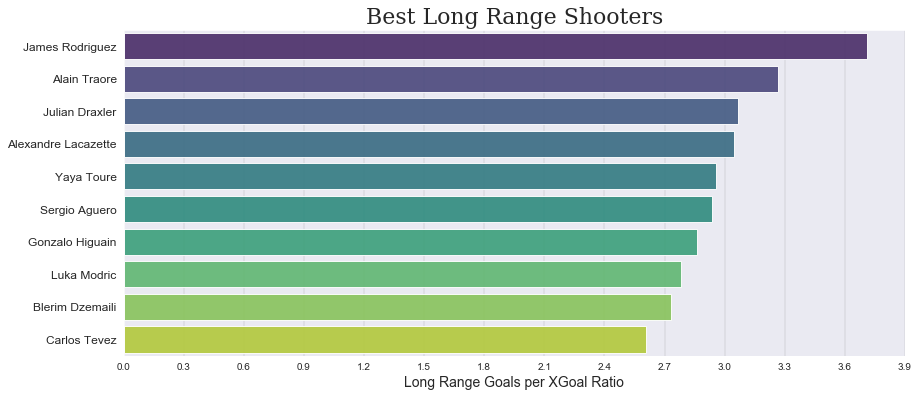

In [88]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[14,6])
ax = sns.barplot(x=show['ratio'], y=show['player'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,4,0.3))
ax.set_xlabel(xlabel='Long Range Goals per XGoal Ratio', fontsize=14)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Best Long Range Shooters", fontsize=22, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

Looks like James Rodriguez is the most efficient outside-the-box shooter in the game.

## 3.h) Which players make the best/most dangerous passes?
By looking at the player who made the pass/through-ball that came prior to the shot, we can evaluate how much xG a player created from his passing.

In [89]:
passing = shots[shots.assist_method.isin([1,4])]
passing_players = passing.groupby('player2').sum().reset_index()
passing_players.rename(columns={'player2': 'player', 'event_type': 'n_passes', 'is_goal': 'trueGoals_created', 'prediction': 'expectedGoals_created'}, inplace=True)
show = passing_players.sort_values('expectedGoals_created', ascending=False).reset_index(drop=True)
show['rank'] = show.index+1
show[['rank', 'player', 'n_passes', 'trueGoals_created', 'expectedGoals_created']].head(5)

,rank,player,n_passes,trueGoals_created,expectedGoals_created
0,1,Lionel Messi,350,68,51.312206
1,2,Mesut Ozil,343,35,36.956771
2,3,Cesc Fabregas,264,53,36.391471
3,4,Zlatan Ibrahimovic,270,36,36.165870
4,5,Marek Hamsik,370,50,34.947915


This is getting a bit boring, but once again we find Messi at the top. In this case, he is the player who has created the most expected goals for his teammates from his passing across the 7 years of our data.

We can now instead look at the mean xG of these passes to see who are the players who try the most dangerous passing.

In [90]:
show['xG_perpass'] = show['expectedGoals_created'] / show['n_passes']
show = show[show['n_passes']>80].sort_values('xG_perpass', ascending=False).reset_index(drop=True)
show['rank'] = show.index+1
show = show[['rank', 'player', 'n_passes', 'xG_perpass']].head(10)
show.head(5)

,rank,player,n_passes,xG_perpass
0,1,Luis Suarez,185,0.165002
1,2,Gareth Bale,109,0.156122
2,3,Angel Di Maria,211,0.151179
3,4,Raul Garcia,90,0.149355
4,5,Lionel Messi,350,0.146606


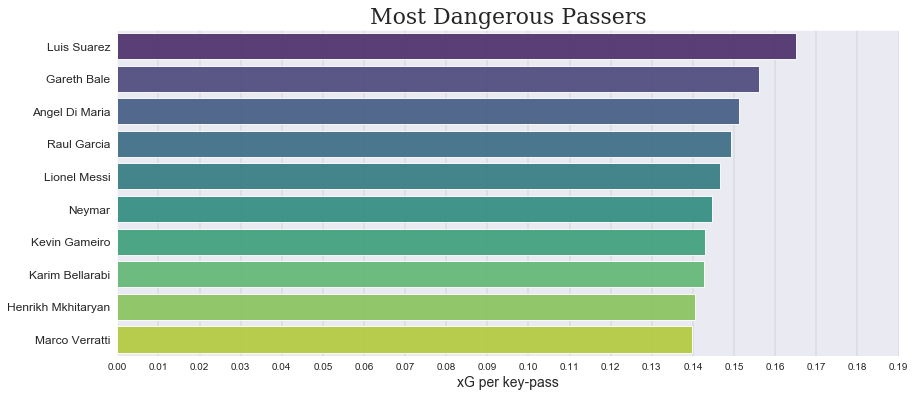

In [91]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[14,6])
ax = sns.barplot(x=show['xG_perpass'], y=show['player'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,0.2,0.01))
ax.set_xlabel(xlabel='xG per key-pass', fontsize=14)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Most Dangerous Passers", fontsize=22, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

We can see Luis Suarez, Di Maria, and Gareth Bale among the players who make, on average, the most dangerous passes, as measured by the expected goals value of the subsequent shot.

## 3.i) Which players are the most unlucky when passing the ball?
We can also see who the most unlucky players are when it comes to passing. Those who have the largest difference between the number of goals that was expected to result from their passes, and the number of goals that actually came from them. I say unlucky because, unlike the player who makes the shot, this other player has no responsibility in whether his team-mates were able to score after his great pass or not!

In [93]:
passing = shots[shots.assist_method.isin([1,4])]
passing_players = passing.groupby('player2').sum().reset_index()
passing_players.rename(columns={'player2': 'player', 'event_type': 'n_passes', 'is_goal': 'trueGoals_created', 'prediction': 'expectedGoals_created'}, inplace=True)
show = passing_players[passing_players['n_passes']>50].sort_values('difference', ascending=False).reset_index(drop=True)
show['rank'] = show.index+1
show[['rank', 'player', 'n_passes', 'trueGoals_created', 'expectedGoals_created', 'difference']].head(5)

,rank,player,n_passes,trueGoals_created,expectedGoals_created,difference
0,1,Joan Verdu,134,7,14.601339,7.601339
1,2,Xabi Prieto,152,6,13.336985,7.336985
2,3,Luca Cigarini,164,6,13.155380,7.155380
3,4,Philippe Coutinho,177,13,20.034535,7.034535
4,5,Alejandro Gomez,137,5,11.766678,6.766678


In [94]:
show[['rank', 'player', 'n_passes', 'trueGoals_created', 'expectedGoals_created', 'difference']].tail(5)

,rank,player,n_passes,trueGoals_created,expectedGoals_created,difference
686,687,Marek Hamsik,370,50,34.947915,-15.052085
687,688,Cristiano Ronaldo,222,45,29.276432,-15.723568
688,689,Cesc Fabregas,264,53,36.391471,-16.608529
689,690,Lionel Messi,350,68,51.312206,-16.687794
690,691,Karim Benzema,214,40,23.301439,-16.698561


We can see that the bottom of the list is filled with players from the strongest teams. This makes sense, as their teammates are usually good and so they are expected to score the chances that are created to them.

At the top of the list we also see some famous unlucky players though, such as Philippe Coutinho and Eden Hazard, who should have seen higher numbers in their "Assists" stats according to the chances they created for the team. This does not speak highly of their team-mates at Liverpool or Chelsea from 2011 to 2016. In other words, if their teammates were finishing those plays with at least an average efficiency, both Coutinho and Hazard would have gotten more assists during those seasons than what appears on official stats.